In [ ]:
!pip install flair
!pip install sentence-transformers

import numpy as  np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


import torch 
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

from flair.embeddings import FlairEmbeddings, TransformerWordEmbeddings , TransformerDocumentEmbeddings, SentenceTransformerDocumentEmbeddings
from flair.data import Sentence

In [92]:
# loading augmented data
import pickle 
labels = ['toxic', 'severe_toxic',  'obscene', 'threat', 'insult','identity_hate']

X_train = [0] * 6
y_train = [0] * 6
for k in range(6):
  with open('drive/MyDrive/CS247/augmented_data/' + labels[k] + '_train.pkl' ,'rb') as fid:
         X_train[k]= pickle.load(fid)
  with open('drive/MyDrive/CS247/augmented_data/' + labels[k] + '_labels.pkl','rb') as fid:
         y_train[k] = pickle.load(fid)

with open('drive/MyDrive/CS247/train_data.pkl', 'rb') as fid:
     train_data= pickle.load(fid)

with open('drive/MyDrive/CS247/valid_data.pkl', 'rb') as fid:
     valid_data= pickle.load(fid)

with open('drive/MyDrive/CS247/test_data.pkl', 'rb') as fid:
     test_data= pickle.load(fid)

with open('drive/MyDrive/CS247/sen_emb_valid.pkl','rb') as fid:
      xvalid = pickle.load(fid)

with open('drive/MyDrive/CS247/sen_emb_test.pkl','rb') as fid:
      xtest = pickle.load(fid)

with open('drive/MyDrive/CS247/augmented_sen_emb_all_train.pkl','rb') as fid:
         X_train_all= pickle.load(fid)

In [93]:
nan_value = float("NaN")

train_data.replace("", nan_value, inplace=True)

train_data.dropna(inplace=True)

valid_data.replace("",nan_value,inplace=True)
valid_data.dropna(inplace=True)

test_data.replace("",nan_value,inplace=True)
test_data.dropna(inplace=True)


In [94]:
y_toxic_valid= valid_data['toxic'].values
y_severe_toxic_valid = valid_data['severe_toxic'].values
y_obscene_valid = valid_data['obscene'].values
y_threat_valid = valid_data['threat'].values
y_insult_valid = valid_data['insult'].values
y_identity_hate_valid = valid_data['identity_hate'].values

y_toxic_test= test_data['toxic'].values
y_severe_toxic_test = test_data['severe_toxic'].values
y_obscene_test = test_data['obscene'].values
y_threat_test = test_data['threat'].values
y_insult_test = test_data['insult'].values
y_identity_hate_test = test_data['identity_hate'].values

In [11]:
bert_emb = TransformerDocumentEmbeddings('bert-base-uncased',fine_tune=False).to(device)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [13]:
def get_embeddings(text):
    sentence = Sentence(text)
    bert_emb.embed(sentence)
    return sentence.embedding.to(device)



def sentence_vec(data):
    # the returned embedding is a tensor 

    # detach = lambda x : x.detach().numpy()
    # emb  = lambda x : get_embeddings(x)
    # data['sen_emb'] = data.comment.apply(emb)
    # # data['sen_emb'] = data.comment.map(get_embeddings)
    # data['sen_emb'] = data.sen_emb.apply(detach,meta=pd.Series([], dtype=np.float32, name='sen_emb'))
  
    for i in range(0, len(data)):
        yield get_embeddings(data[i])
    # for i in range(0, len(data), batch_size):
    #   map(get_embeddings,data[i:i+batch_size])
    # data['sen_emb'] = data.sen_emb.apply(lambda x: np.array(x))

def detach(data):
    for i in range(0,len(data)):
      yield torch.Tensor.cpu(data[i]).detach().numpy()


def apply_sentence_embeddings(df_train,df_test):
    sentence_vec(df_train)
    sentence_vec(df_test)



In [21]:
augmented_emb_train = [0] * 6
for i,x in enumerate(X_train):
    res1 = []
    res2 =[]
    for item in sentence_vec(x):
      res1.append(item)
    for item in detach(res1):
      res2.append(item)
    augmented_emb_train[i]=res2 

with open('augmented_sen_emb_all_train.pkl', 'wb') as f:
    pickle.dump(augmented_emb_train, f)

In [72]:
from sklearn.model_selection import cross_validate as cross_validation, ShuffleSplit, cross_val_score, train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score,roc_curve, f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


def classifier_validation(X_train,Y_train,X_test,Y_test):
    report_scores = {}
    roc_auc_scores ={}
    roccurve = {}
    f1_scores = {}
    best_thresholds = {}
    classifiers = [LogisticRegression(max_iter=700,class_weight='balanced'),BernoulliNB()]
    random = [ 0 for _ in range(len(Y_test))]
    r_score = roc_auc_score(Y_test,random)
    r_fpr , r_tpr, thresholds = roc_curve(Y_test,random)
    random_eval = r_score , r_fpr, r_tpr 
    for classifier in (classifiers):
        classifier.fit(X_train, Y_train)
        probs = classifier.predict_proba(X_test)
        roc_auc_scores[classifier.__class__.__name__] = roc_auc_score(Y_test,probs[:,1]) 
        roc_fpr , roc_tpr, threshold= roc_curve(Y_test,probs[:,1])
        gmeans = np.sqrt(roc_tpr * (1-roc_fpr))
        ix = np.argmax(gmeans)
        best_thresholds[classifier.__class__.__name__] = threshold[ix]
        roccurve[classifier.__class__.__name__] = roc_fpr, roc_tpr 
        predictions = classifier.predict(X_test)
        f1_scores[classifier.__class__.__name__] = f1_score(Y_test,predictions)
        report = classification_report(Y_test, predictions)
        report_scores[classifier.__class__.__name__] = report
        # print(classifier.__class__.__name__ + ":")
        # print(report)
        # print('------------------------------------------------------')
    return report_scores,roc_auc_scores, roccurve, random_eval,f1_scores, best_thresholds

def eval_BERT(xtrain,xtest,Train_Y,Test_Y):
  xtrain = np.array(xtrain)
  xtest = np.array(xtest)
  report_scores, aucscores, roccurve, random, f1scores,best_thresholds = classifier_validation(xtrain,Train_Y,xtest,Test_Y) 
  return report_scores, aucscores, roccurve, random, f1scores, best_thresholds


def plot_roc_curve(roccurve,aucscores,random):
    bn_fpr , bn_tpr = roccurve['BernoulliNB']
    bn_roc_scores = aucscores['BernoulliNB']
    lr_fpr , lr_tpr = roccurve['LogisticRegression']
    lr_roc_scores = aucscores['LogisticRegression']
    r_scores , r_fpr , r_tpr = random 
    plt.plot(r_fpr,r_tpr,linestyle='--',label ='Random prediction (AUROC = %0.3f)'%r_scores)
    plt.plot(bn_fpr,bn_tpr,linestyle='dotted',label='BernouilliNB (AUROC = %0.3f' %bn_roc_scores)
    plt.plot(lr_fpr,lr_tpr,linestyle='dotted',label='LogisticRegression (AUROC = %0.3f' %lr_roc_scores)
    plt.title('ROC PLOT')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [91]:
labels = ['toxic', 'severe_toxic',  'obscene', 'threat', 'insult','identity_hate']
toxic = X_train_all[0]
severe_toxic = X_train_all[1]
obscene = X_train_all[2]
threat= X_train_all[3]
insult = X_train_all[4]
identity_hate = X_train_all[5]

y_toxic = y_train[0]
y_severe_toxic = y_train[1]
y_obscene = y_train[2]
y_threat = y_train[3]
y_insult = y_train[4]
y_identity_hate = y_train[5]


VALIDATING MODEL WITH ROC CURVES 

OBSCENE EVALUATION

In [ ]:
scores , aucscores, roccurve, random, f1scores, best_thresholds = eval_BERT(obscene,xvalid,y_obscene,y_obscene_valid)
for key, value in f1scores.items():
    print(key, ' : ', value)

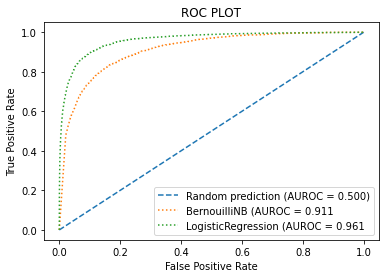

In [86]:
plot_roc_curve(roccurve,aucscores,random)

INSULT EVALUATION

In [61]:
scores , aucscores, roccurve, random, f1scores= eval_BERT(insult,xvalid,y_insult,y_insult_valid)
for key, value in f1scores.items():
    print(key, ' : ', value)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression  :  0.48481936971560335
BernoulliNB  :  0.36683693516699417


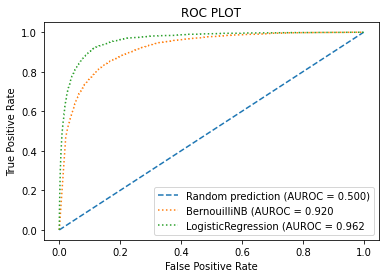

In [62]:
plot_roc_curve(roccurve,aucscores,random)

THREAT EVALUATION

In [63]:
scores , aucscores, roccurve, random, f1scores = eval_BERT(threat,xvalid,y_threat,y_threat_valid)
for key, value in f1scores.items():
    print(key, ' : ', value)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression  :  0.14393499709808474
BernoulliNB  :  0.050189564903412164


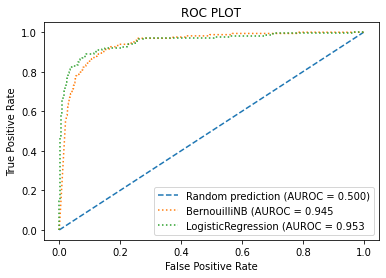

In [64]:
plot_roc_curve(roccurve,aucscores,random)

TOXIC EVALUATION

In [65]:
scores , aucscores, roccurve, random, f1scores= eval_BERT(toxic,xvalid,y_toxic,y_toxic_valid)
for key, value in f1scores.items():
    print(key, ' : ', value)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression  :  0.6011730205278593
BernoulliNB  :  0.46751128269262143


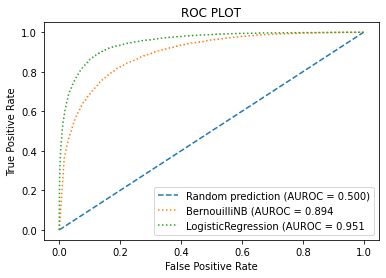

In [66]:
plot_roc_curve(roccurve,aucscores,random)

SEVERE TOXIC EVALUATION

In [67]:
scores , aucscores, roccurve, random, f1scores= eval_BERT(severe_toxic,xvalid,y_severe_toxic,y_severe_toxic_valid)
for key, value in f1scores.items():
    print(key, ' : ', value)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression  :  0.23305588585017836
BernoulliNB  :  0.1486528336946423


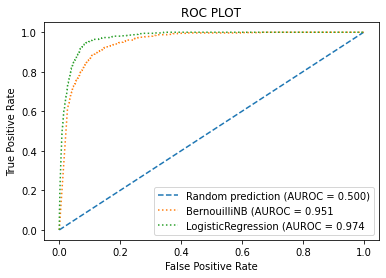

In [68]:
plot_roc_curve(roccurve,aucscores,random)

IDENTITY HATE EVALUATION

In [69]:
scores , aucscores, roccurve, random, f1scores= eval_BERT(identity_hate,xvalid,y_identity_hate,y_identity_hate_valid)
for key, value in f1scores.items():
    print(key, ' : ', value)

LogisticRegression  :  0.15471836137527434
BernoulliNB  :  0.10078549848942597


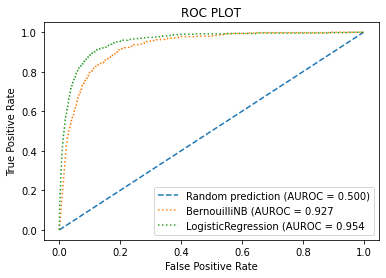

In [70]:
plot_roc_curve(roccurve,aucscores,random)

TESTING THE MODEL

In [95]:
def run_threshold_lr(xtrain,xtest,ytrain,ytest,tr):
    lr = LogisticRegression(max_iter =700,class_weight='balanced')
    lr.fit(xtrain,ytrain)
    probabilities = lr.predict_proba(xtest)
    y_pred = (probabilities[:,1] >= tr).astype(int)
    f1 = f1_score(ytest,y_pred)
    return f1

def run_threshold_nb(xtrain,xtest,ytrain,ytest,tr):
    nb = BernoulliNB()
    nb.fit(xtrain,ytrain)
    probabilities = nb.predict_proba(xtest)
    y_pred = (probabilities[:,1] >= tr).astype(int)
    f1 = f1_score(ytest,y_pred)
    return f1


def calculate_scores(xtrain,xtest,ytrain,ytest,res1,res2,res1_tr,res2_tr,label):
    names = ['LogisticRegression','BernoulliNB']
    _,_,_,_,f1scores,thresholds = eval_BERT(xtrain,xtest,ytrain,ytest)
    lr_tr = thresholds['LogisticRegression']
    nb_tr = thresholds['BernoulliNB']
    lr_tr_score = run_threshold_lr(xtrain,xtest,ytrain,ytest,lr_tr)
    nb_tr_score = run_threshold_nb(xtrain,xtest,ytrain,ytest,nb_tr)
    res1[label] = f1scores[names[0]]
    res2[label] = f1scores[names[1]]
    res1_tr[label] = lr_tr_score
    res2_tr[label] =  nb_tr_score


def final_results(res_lr,res_nb,res_tr_lr,res_tr_nb):
    N = 6
    sum_lr = 0
    sum_nb = 0
    sum_tr_lr = 0
    sum_tr_nb = 0
    for key in res_lr:
         sum_lr += res_lr[key]

    for key in res_nb:
        sum_nb += res_nb[key]

    for key in res_tr_lr:
        sum_tr_lr += res_tr_lr[key]

    for key in res_tr_nb:
        sum_tr_nb += res_tr_nb[key]

    f1average_lr  = sum_lr / N
    f1average_nb  = sum_nb / N
    f1average_tr_lr = sum_tr_lr / N
    f1average_tr_nb = sum_tr_nb / N
    return f1average_lr , f1average_nb, f1average_tr_lr , f1average_tr_nb



def run_all_classifiers():
    results_lr = {}
    results_nb = {}
    results_lr_tr = {}
    results_nb_tr = {}
    all_y_test = [y_toxic_test,y_severe_toxic_test,y_obscene_test,y_threat_test,y_insult_test,y_identity_hate_test]
    labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
    for i in range(len(y_train)):
        calculate_scores(X_train_all[i],xtest,y_train[i],all_y_test[i],results_lr,results_nb,results_lr_tr,results_nb_tr,labels[i])
    
    res1,res2,res3,res4 = final_results(results_lr,results_nb,results_lr_tr,results_nb_tr)
    return res1, res2,res3,res4



In [96]:
f1average_lr , f1average_nb, f1average_lr_tr , f1average_nb_tr  = run_all_classifiers()
print('Logistic Regression F1 score : ', f1average_lr)
print('BernoulliNB F1 score : ',f1average_nb)
print('Logistic Regression with threshold F1 score :', f1average_lr_tr )
print('BernoulliNB with threshold  F1 score : ',f1average_nb_tr)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Logistic Regression F1 score :  0.29122710525163575
BernoulliNB F1 score :  0.2226321952674514
Logistic Regression with threshold F1 score : 0.26537894139518126
BernoulliNB with threshold  F1 score :  0.2169748038087096
